# Built-in Task Models

During pre-training, META-SiM learned many task models already. They can be loaded and applied to your dataset without tuning. These models include (in the parathesis is their model name):

- Signal-to-noise (NOISELEVEL)
- Mean dwell time in frames(DWELLTIME)
- Mean kinetic rate constant in frames^-1(TRANSITIONRATE)
- Number of FRET transitions (NBD)
- Number of distinct FRET counts (FRETSTATECOUNT)
- Acceptor Lifetime in frames (ACCEPTORLIFETIME)
- Donor Lifetime in frames (DONORLIFETIME)
- Number of photobleaching steps (MULTISTEP)
- Signal-to-noise for single color data (SINGLECHANNELNOISELEVEL)
- Mean dwell time for single color data (SINGLECHANNELDWELLTIME)
- Lifetime for single color data (SINGLECHANNELLIFETIME)


These task models may not be as accurate as tuned models specifically fitted to your dataset. So we recommend you tune your own model with a few hundreds to one thousand high-quality manual labeled traces instead of directly using the built-in task models.

In [ ]:
! git clone https://github.com/simol-lab/META-SiM.git
! cp -r META-SiM/tutorials/saved_dataset .
! pip install metasim

In [1]:
import openfret
import metasim
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics

# Load example data

We will use the data in paper:

Widom, J. R. et al. Ligand Modulates Cross-Coupling between Riboswitch Folding and Transcriptional
Pausing. Mol. Cell 72, 541-552.e6 (2018). 

to demonstrate how to use built-in models.

In [2]:
data = metasim.fret.data.TwoColorDataset(
    openfret.read_data('saved_dataset/openfret/cond_4_train.json.zip'),
)

In [3]:
model = metasim.fret.Model()
with tf.device('/CPU:0'):
    # If your GPU is faster than CPU, change the device to /GPU:0.
    embedding = model(data)

  0%|          | 0/2353 [00:00<?, ?it/s]

# Load a built-in model

To load a built-in model, you can find the name in this list:

In [109]:
metasim.fret.tuning.TASKS

[['DWELLTIME', 'TRANSITIONPROBQUICK', 'NBDQUICK', 'NBD', 'TRANSITIONRATE'],
 ['FRETSTATECOUNT'],
 ['FRETSTATEHIGHEST', 'FRETSTATELOWEST'],
 ['MULTISTEP', 'COINCIDENCE'],
 ['ACCEPTORLIFETIME'],
 ['DONORLIFETIME'],
 ['NOISELEVEL', 'BACKGROUND'],
 ['SINGLECHANNELDWELLTIME', 'SINGLECHANNELLIFETIME'],
 ['SINGLECHANNELPHOTOBLEACHINGSTEPSTRACE'],
 ['SINGLECHANNELNOISELEVEL']]

Let's calculate the donor / acceptor lifetime for the traces first.

In [110]:
donor_lifetime_model = metasim.fret.tuning.ModelConfig.load_from_task(
    'DONORLIFETIME',
)
acceptor_lifetime_model = metasim.fret.tuning.ModelConfig.load_from_task(
    'ACCEPTORLIFETIME',
)

In [111]:
donor_lifetime = donor_lifetime_model.predict(embedding)
acceptor_lifetime = acceptor_lifetime_model.predict(embedding)

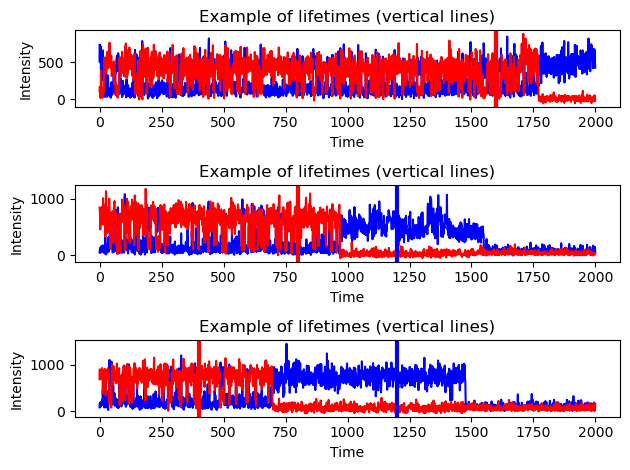

In [112]:
fig, axes = plt.subplots(3)
count = 0
for i, trace in enumerate(data.traces):
    if not trace.metadata['manual_label']:
        continue
    for channel in trace.channels:
        if channel.channel_type == 'donor':
            color = 'b'
        elif channel.channel_type == 'acceptor':
            color = 'r'
        axes[count].plot(channel.data, color=color)
        axes[count].set_ylabel('Intensity')
        axes[count].set_xlabel('Time')
        axes[count].set_title('Example of lifetimes (vertical lines)')
    axes[count].axvline(donor_lifetime[i], color='b', linewidth=3)
    axes[count].axvline(acceptor_lifetime[i], color='r', linewidth=3)
    count += 1
    if count == len(axes):
        break
plt.tight_layout()

Let's look at the signal-to-noise next.

In [113]:
snr_model = metasim.fret.tuning.ModelConfig.load_from_task(
    'NOISELEVEL',
)

In [114]:
snr = snr_model.predict_regression(embedding)

Let's then look at the count of photobleaching steps and the count of FRET states.

In [115]:
steps_model = metasim.fret.tools.tuning.ModelConfig.load_from_task(
    'MULTISTEP',
)
states_model = metasim.fret.tools.tuning.ModelConfig.load_from_task(
    'FRETSTATECOUNT'
)

In [116]:
photobleach_steps = steps_model.predict(embedding)
fret_state_count = states_model.predict(embedding)

A very basic thresholding method to select "good" trace is:
- long acceptor lifetime
- no multistep photobleaching
- have kinetic states

Let's use this toy criteria to examin the manual label.

In [117]:
rubric_label = (
    (acceptor_lifetime > 200) & 
    (photobleach_steps <= 2) &
    (fret_state_count > 1)
)

In [118]:
label = np.array([trace.metadata['manual_label'] for trace in data.traces])

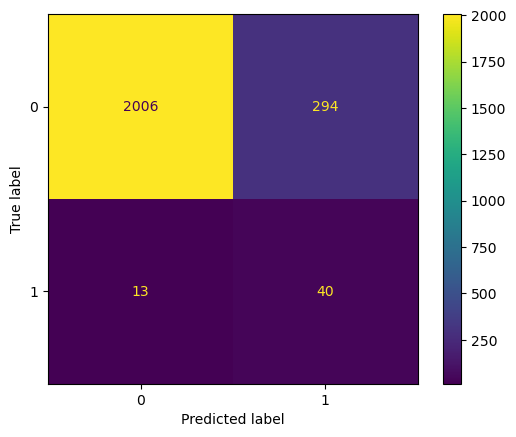

In [119]:
metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(y_true=label, y_pred=rubric_label),
).plot()

The simple rubric can already help filter >80% "bad" traces while only incorrectly filtered ~20% of "good traces".